In [13]:
import numpy as np
from scipy.sparse import linalg
import matplotlib.pyplot as plt
from importlib import reload
import time
%matplotlib inline

import H_mat

# Итерационный метод решения системы с Н-матрицей

В файле [H_mat.ipynb](https://nbviewer.jupyter.org/github/pimanov/H_matrix/blob/master/H_mat.ipynb) (H_mat.pdf) были описаны прямые методы для решения линейной системы с Н-матрицей. Данный файл посвящен итерационным метода решения таких систем. Основная операция, необходимая для применения крыловских методов - умножение матрицы на вектор, которое может быть эффективно реализовано в Н-формате.

Будем решать систему Am = b c матрицей $A \in R^{n \times n}$, определенную следующим образом:

$$
A_{i,j,i \ne j} = log(|x_i - x_j|), 
$$

$$
A_{i,i} = 100
$$

$$
x_i = \frac{i}{n}
$$

Единственное отличие матрицы A, определенной таким образом, от матрицы, определенной в файле H_mat.ipynb, состоит в том, что диагональные элементы равны 100, а не нулю. Я решил изменить диагональные элементы для того, чтобы итерационный метод лучше сходился. Наибольший по амплитуде внедиагональный элемент равен -108, так что значение диагональных элементов оказывается вполне соизмеримо со значениями других элементов в матрице.

Ниже еще раз определены функции для построения плотной матрицы для данной системы.

In [439]:
def kernel(x, y):
    return np.log(np.abs(x - y))

In [441]:
def gen_matrix(n):
    xs = np.linspace(0, 1, n)
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                A[i, j] = kernel(xs[i], xs[j]) 
            else:
                A[i, j] = 100
    return A

## Сложность умножения матрицы на вектор

Ниже приведено время, необходимое для выполнения умножения на вектор Н-матрицы и плотной матрицы. Для плотной матрицы умножение выполняется в модуле numpy (lapack). 

Построим серию матриц с n = [100, 200, 400, 800, 1600, 3200, 6400]

In [442]:
ns = [100, 200, 400, 800, 1600, 3200, 6400]
h_mat = []
dens_mat = []

for n in ns:
    A = gen_matrix(n)
    dens_mat.append(A)
    H = H_mat.create(A, 1e-6, 10)
    h_mat.append(H)

Ниже определяется время, необходимое для умножения матрицы на вектор.

In [179]:
h_vmul_time = []

for H, n in zip(h_mat, ns):
    m = 100
    x = np.random.rand(n)
    
    time1 = time.process_time()
    for i in range(m):
        b = H @ x
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    h_vmul_time.append(dtime)

In [180]:
dens_vmul_time = []

for A in dens_mat:
    m = 100
    x = np.random.rand(m1.shape[1])
    
    time1 = time.process_time()
    for i in range(m):
        b = A @ x
    time2 = time.process_time()
    
    dtime = (time2 - time1) / m
    dens_vmul_time.append(dtime)

Время выполнения matvec для Н-матрицы имеет линейную сложность (синяя линия), время matvec для плотной матрицы имеет квадратичную сложность (оранжевая линия). Несмотря на то, что сравнение проводится с высоко оптимизированной библиотекой Lapack, уже при n=1000 умножение в Н-формате оказывается быстрее умножения с плотной матрицей. Это, в частности, значит, что итерационные методы в Н-формате будут работать быстрее, чем с плотной матрицей.

Text(0, 0.5, 'time (s)')

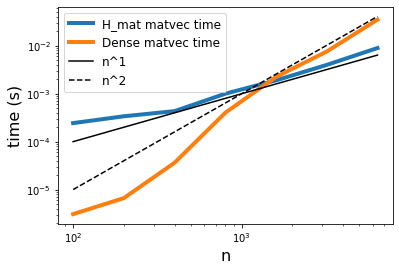

In [375]:
plt.loglog(ns, h_vmul_time, label="H_mat matvec time", lw=4)
plt.loglog(ns, dens_vmul_time, label="Dense matvec time", lw=4)
plt.plot(ns, [n/1e6 for n in ns], 'k-', label="n^1")
plt.plot(ns, [n**2/1e9 for n in ns], 'k--',label="n^2")
plt.legend(fontsize=12)
plt.xlabel("n", fontsize=16)
plt.ylabel("time (s)", fontsize=16)

## Итерационное решение системы с Н-матрицей

Решим систему Am = b итерационным солвером gmres, реализованным в библиотеке scipy. Предобуславливатель на данном этапе не используется.

Построим плотную матрицу A, соответствующую ей Н-матрицу H и случайную правую часть b

In [416]:
A = gen_matrix(3000)
H = H_mat.create(A, 1e-6, 10)
b = np.random.rand(3000)

Ниже методом gmres решается система с плотной матрицей и определяется время решения. Оно составляется 0.68 секунды.

In [432]:
time1 = time.process_time()
m, info = scipy.sparse.linalg.gmres(A, b, tol=1e-7, restart=100)
time2 = time.process_time()

dtime = time2 - time1
print ("running time in seconds = ", dtime)

running time in seconds =  0.6866730000001553


Как показывают следующие вычисления, решение было найдено с точностью 1е-6

In [433]:
np.linalg.norm(A @ m - b)

1.5571690937644997e-06

Ниже определяется линейный оператор для вычисления произведения Н-матрицы и вектора, который будет передан в функцию gmres

In [421]:
H_op = scipy.sparse.linalg.LinearOperator(shape=A.shape, matvec=lambda x: H.dot(x))

Определив линейный оператор, применяем gmres для решения системы с Н-матрицей. Время решения составляется 0.37 секунды, что почти в два раза быстрее, чем при решении с плотной матрицей. 

In [437]:
time1 = time.process_time()
m, info = scipy.sparse.linalg.gmres(H_op, b, tol=1e-7, restart=100)
time2 = time.process_time()

dtime = time2 - time1
print ("running time in seconds =", dtime)

running time in seconds = 0.3677860000002511


Как показывает следующий расчет, как и в первом случае, решение найдено с точностью 1е-6.

In [438]:
np.linalg.norm(H @ m - b)

1.5571694319774287e-06

## Заключение

Асимптотическая сложность умножения Н-матрицы на вектор ниже, чем сложность умножения плотной матрицы на вектор, и уже при n = 1000 уножение в Н-формате требует меньше времени. Это ведет к тому, что крыловские методы решения линейных систем эффективнее работают с Н-матрицами. Выше показано, что для системы с 3000 неизвестными gmres с Н-матрицей оказывается вдвое эффективнее, чем gmres с плотной матрицей.

В будущем я мог бы реализовать итерационный метод самостоятельно, но на это нужно немного больше времени. Эта работа сделана за день.